# **Import libraries**

In [93]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import keras
from keras import layers
import tensorflow as tf
from keras.utils import pad_sequences
from keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# **Use GPU device**

In [94]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **DNA Sequence Classification**

# Data Preprocessing

In [3]:
#
# Load data from file path
#
def read_data(path):
  f = open(path)
  text = f.read()
  datas = re.split('\n\n',text)
  for i in range(len(datas)):
      x = re.split('\n', datas[i])
      dna_sequence = ''
      for j in range(1, len(x)):
          dna_sequence += x[j]
      datas[i] = dna_sequence
  return datas

In [21]:
#
# Convert data from character to number
#
mapping = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
def data_preprocessing(data):
    results = []
    for row in data:
        check = False
        arr = []
        for i in range(len(row)):
            if(row[i] not in mapping.keys()):
                check = True
                break
            arr.append(mapping[row[i]])
        if(check == False and 500 <= len(arr) <= 30000):
            results.append(arr)
    return results


In [6]:
#
# Reading data
#
mers_data = read_data('/kaggle/input/dna-sequence/MERS.fasta')
sars_data = read_data('/kaggle/input/dna-sequence/SARS.fasta')
covid_data = read_data('/kaggle/input/dna-sequence/COVID-19-2.fasta')
dengue_data = read_data('/kaggle/input/dna-sequence/dengue.fasta')

In [22]:
#
# Encoding data
#
mers_encoding = data_preprocessing(mers_data)
sars_encoding = data_preprocessing(sars_data)
covid_encoding = data_preprocessing(covid_data)
dengue_encoding = data_preprocessing(dengue_data)
# influenza_encoding = data_preprocessing(influenza_data)
# hepatitis_encoding = data_preprocessing(hepatitis_data)

In [96]:
mers_data = pd.DataFrame({"dna": mers_encoding})
sars_data = pd.DataFrame({"dna": sars_encoding})
covid_data = pd.DataFrame({"dna": covid_encoding})
dengue_data = pd.DataFrame({"dna": dengue_encoding})

In [97]:
mers_data['length'] = mers_data['dna'].apply(lambda x: len(x))
sars_data['length'] = sars_data['dna'].apply(lambda x: len(x))
covid_data['length'] = covid_data['dna'].apply(lambda x: len(x))
dengue_data['length'] = dengue_data['dna'].apply(lambda x: len(x))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

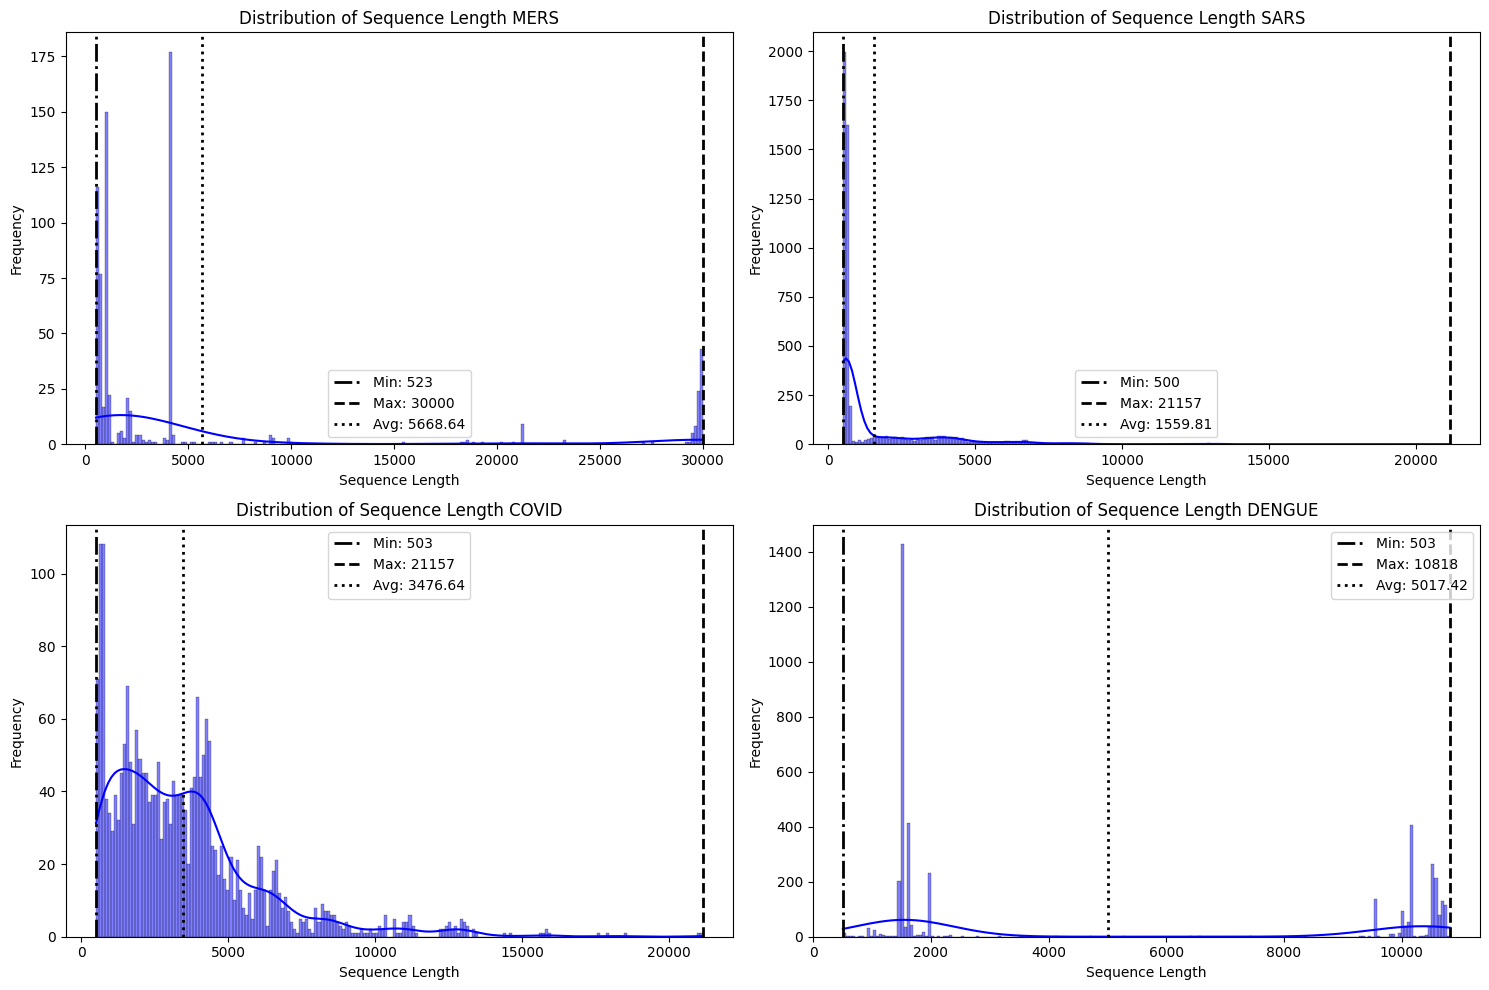

In [99]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
mapName = {0: 'MERS', 1: 'SARS', 2: 'COVID', 3: 'DENGUE'}

# Flatten axes thành một mảng 1D để dễ truy cập
axes = axes.flatten()

# Duyệt qua các tập dữ liệu và vẽ biểu đồ phân phối độ dài của chuỗi
for i, (dataset, ax) in enumerate(zip([mers_data, sars_data, covid_data, dengue_data], axes)):
    # Tính toán độ dài trung bình, tối thiểu và tối đa của chuỗi
    avg_length = dataset['length'].mean()
    max_length = dataset['length'].max()
    min_length = dataset['length'].min()
    
    # Vẽ biểu đồ phân phối độ dài chuỗi
    sns.histplot(dataset['length'], kde=True, color='blue', bins=200, ax=ax)
    ax.axvline(min_length, color='black', linestyle='dashdot', linewidth=2, label=f'Min: {min_length}')
    ax.axvline(max_length, color='black', linestyle='dashed', linewidth=2, label=f'Max: {max_length}')
    ax.axvline(avg_length, color='black', linestyle='dotted', linewidth=2, label=f'Avg: {avg_length:.2f}')
    ax.set_title(f'Distribution of Sequence Length {mapName[i]}')
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Frequency')
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

In [37]:
def translate_codon(codon):
    # Bảng mã hóa từ codon sang axit amin
#     codon_table = {
#         'TTT': 'Phenylalanine', 'TTC': 'Phenylalanine', 'TTA': 'Leucine', 'TTG': 'Leucine',
#         'TCT': 'Serine', 'TCC': 'Serine', 'TCA': 'Serine', 'TCG': 'Serine',
#         'TAT': 'Tyrosine', 'TAC': 'Tyrosine', 'TAA': 'Stop', 'TAG': 'Stop',
#         'TGT': 'Cysteine', 'TGC': 'Cysteine', 'TGA': 'Stop', 'TGG': 'Tryptophan',
#         'CTT': 'Leucine', 'CTC': 'Leucine', 'CTA': 'Leucine', 'CTG': 'Leucine',
#         'CCT': 'Proline', 'CCC': 'Proline', 'CCA': 'Proline', 'CCG': 'Proline',
#         'CAT': 'Histidine', 'CAC': 'Histidine', 'CAA': 'Glutamine', 'CAG': 'Glutamine',
#         'CGT': 'Arginine', 'CGC': 'Arginine', 'CGA': 'Arginine', 'CGG': 'Arginine',
#         'ATT': 'Isoleucine', 'ATC': 'Isoleucine', 'ATA': 'Isoleucine', 'ATG': 'Methionine',
#         'ACT': 'Threonine', 'ACC': 'Threonine', 'ACA': 'Threonine', 'ACG': 'Threonine',
#         'AAT': 'Asparagine', 'AAC': 'Asparagine', 'AAA': 'Lysine', 'AAG': 'Lysine',
#         'AGT': 'Serine', 'AGC': 'Serine', 'AGA': 'Arginine', 'AGG': 'Arginine',
#         'GTT': 'Valine', 'GTC': 'Valine', 'GTA': 'Valine', 'GTG': 'Valine',
#         'GCT': 'Alanine', 'GCC': 'Alanine', 'GCA': 'Alanine', 'GCG': 'Alanine',
#         'GAT': 'Aspartic Acid', 'GAC': 'Aspartic Acid', 'GAA': 'Glutamic Acid', 'GAG': 'Glutamic Acid',
#         'GGT': 'Glycine', 'GGC': 'Glycine', 'GGA': 'Glycine', 'GGG': 'Glycine'
#     }

    codon_table = {
        '111': 'Phenylalanine', '112': 'Phenylalanine', '113': 'Leucine', '114': 'Leucine',
        '121': 'Serine', '122': 'Serine', '123': 'Serine', '124': 'Serine',
        '131': 'Tyrosine', '132': 'Tyrosine', '133': 'Stop', '134': 'Stop',
        '141': 'Cysteine', '142': 'Cysteine', '143': 'Stop', '144': 'Tryptophan',
        '211': 'Leucine', '212': 'Leucine', '213': 'Leucine', '214': 'Leucine',
        '221': 'Proline', '222': 'Proline', '223': 'Proline', '224': 'Proline',
        '231': 'Histidine', '232': 'Histidine', '233': 'Glutamine', '234': 'Glutamine',
        '241': 'Arginine', '242': 'Arginine', '243': 'Arginine', '244': 'Arginine',
        '311': 'Isoleucine', '312': 'Isoleucine', '313': 'Isoleucine', '314': 'Methionine',
        '321': 'Threonine', '322': 'Threonine', '323': 'Threonine', '324': 'Threonine',
        '331': 'Asparagine', '332': 'Asparagine', '333': 'Lysine', '334': 'Lysine',
        '341': 'Serine', '342': 'Serine', '343': 'Arginine', '344': 'Arginine',
        '411': 'Valine', '412': 'Valine', '413': 'Valine', '414': 'Valine',
        '421': 'Alanine', '422': 'Alanine', '423': 'Alanine', '424': 'Alanine',
        '431': 'Aspartic Acid', '432': 'Aspartic Acid', '433': 'Glutamic Acid', '434': 'Glutamic Acid',
        '441': 'Glycine', '442': 'Glycine', '443': 'Glycine', '444': 'Glycine'
    }
    
    # Kiểm tra xem codon có trong bảng mã hóa không
    if codon in codon_table:
        return codon_table[codon]
    else:
        return 'Unknown'

In [63]:
def translate_dna_sequences(dna_sequences):
    axitamin_list = []
    
    for dna_sequence in dna_sequences:
        for i in range(0, len(dna_sequence) - 3, 3):
            da = [str(x) for x in dna_sequence[i:i+3]]
            codon = ''.join(da)
            amino_acid = translate_codon(codon)
            if amino_acid != 'Stop':
                axitamin_list.append(amino_acid)
            else:
                break  
    return axitamin_list

In [88]:
axitamin_covid = translate_dna_sequences(covid_encoding)
axitamin_mers = translate_dna_sequences(mers_encoding)
axitamin_sars = translate_dna_sequences(sars_encoding)
axitamin_dengue = translate_dna_sequences(dengue_encoding)

In [89]:
axitamin_covid_data = pd.DataFrame({'axitamin': axitamin_covid})
axitamin_mers_data = pd.DataFrame({'axitamin': axitamin_mers})
axitamin_sars_data = pd.DataFrame({'axitamin': axitamin_sars})
axitamin_dengue_data = pd.DataFrame({'axitamin': axitamin_dengue})

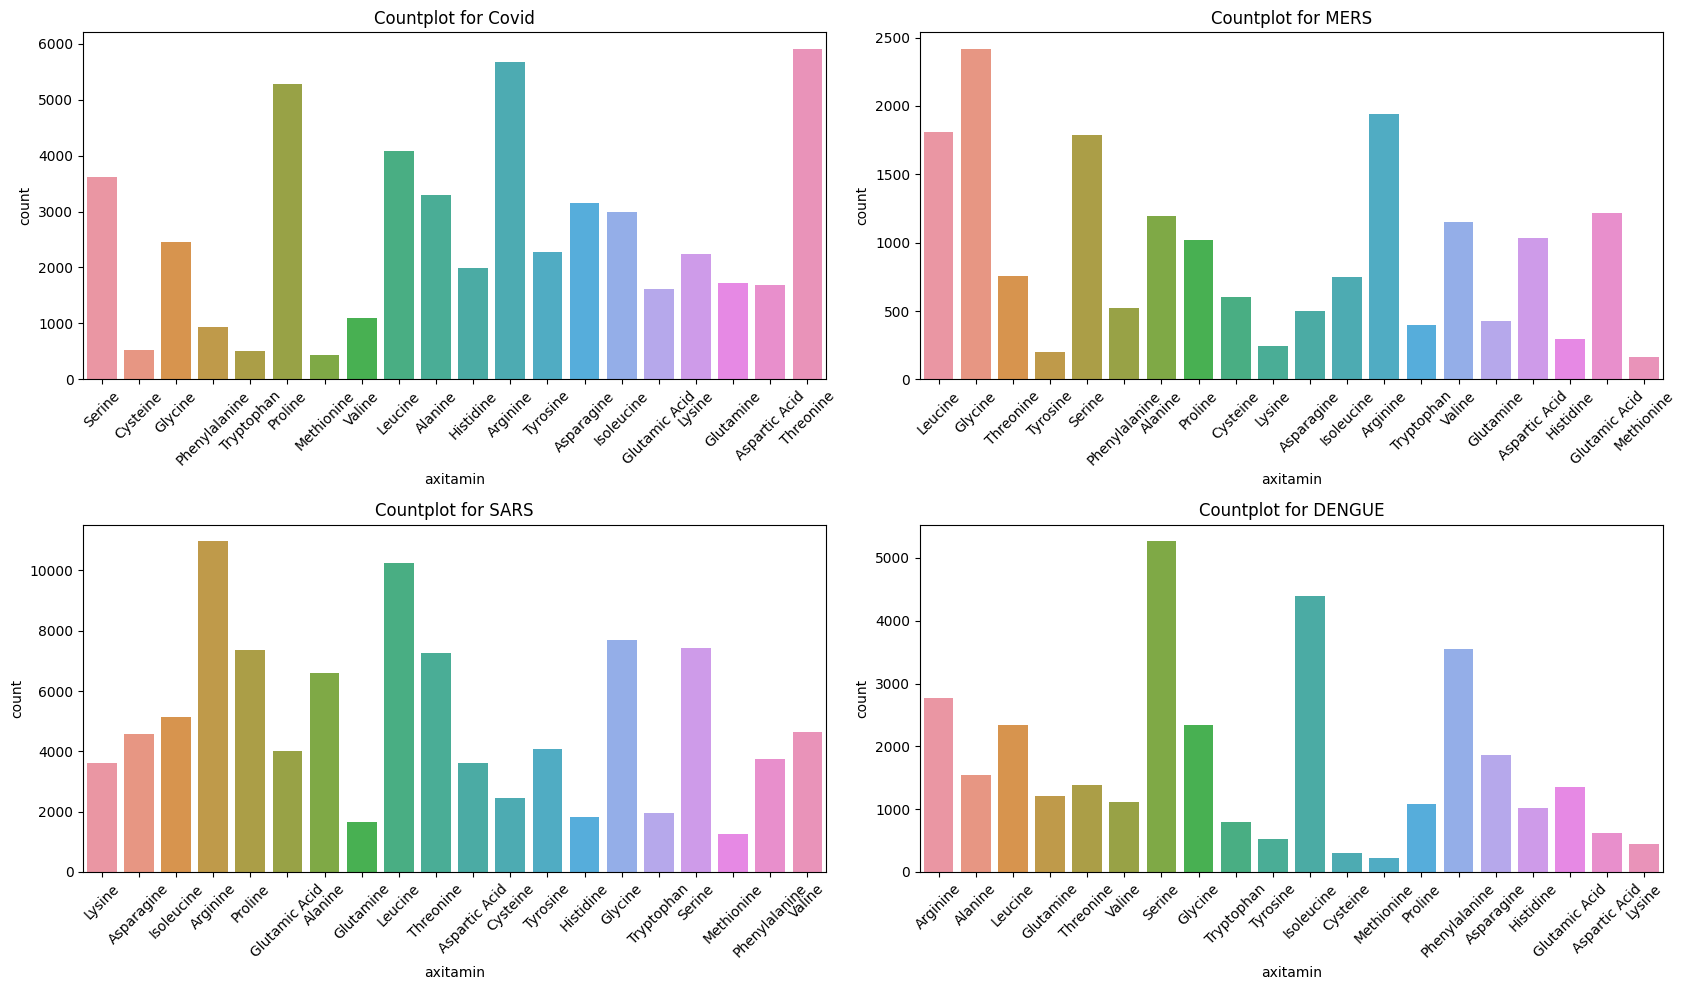

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(17, 10))

# Flatten axes thành một mảng 1D để dễ truy cập
axes = axes.flatten()

# Vẽ biểu đồ cho train_data
plt.sca(axes[0])
plt.xticks(rotation=45)
plt.xlabel('axit amin')
sns.countplot(data=axitamin_covid_data, x='axitamin')
plt.title('Countplot for Covid')

# Vẽ biểu đồ cho train_data1
plt.sca(axes[1])
plt.xticks(rotation=45)
plt.xlabel('axit amin')
sns.countplot(data=axitamin_mers_data, x='axitamin')
plt.title('Countplot for MERS')

# Vẽ biểu đồ cho train_data2
plt.sca(axes[2])
plt.xticks(rotation=45)
plt.xlabel('axit amin')
sns.countplot(data=axitamin_sars_data, x='axitamin')
plt.title('Countplot for SARS')

# Vẽ biểu đồ cho train_data3
plt.sca(axes[3])
plt.xticks(rotation=45)
plt.xlabel('axit amin')
sns.countplot(data=axitamin_dengue_data, x='axitamin')
plt.title('Countplot for DENGUE')

plt.tight_layout()
plt.show()

In [101]:
#
# Labeling data
#
mers_label = [0] * len(mers_encoding)
sars_label = [1] * len(sars_encoding)
covid_label = [2] * len(covid_encoding)
# influenza_label = [3] * len(influenza_encoding)
dengue_label = [3] * len(dengue_encoding)
# hepatitis_label = [4] * len(hepatitis_encoding)

In [102]:
#
# Create data with DataFrame format
#
train_data = pd.DataFrame({'dna': mers_encoding + sars_encoding + covid_encoding + dengue_encoding, 'label': mers_label + sars_label + covid_label +dengue_label})
train_data.head()

,dna,label
0,"[1, 3, 4, 3, 1, 1, 4, 1, 3, 2, 4, 4, 3, 3, 2, ...",0
1,"[1, 1, 4, 4, 4, 3, 4, 4, 4, 3, 2, 3, 1, 3, 2, ...",0
2,"[1, 1, 4, 4, 4, 3, 4, 4, 4, 3, 2, 3, 1, 3, 2, ...",0
3,"[1, 1, 4, 4, 4, 3, 4, 4, 4, 3, 2, 3, 1, 3, 2, ...",0
4,"[1, 1, 4, 4, 4, 3, 4, 4, 4, 3, 2, 3, 1, 3, 2, ...",0


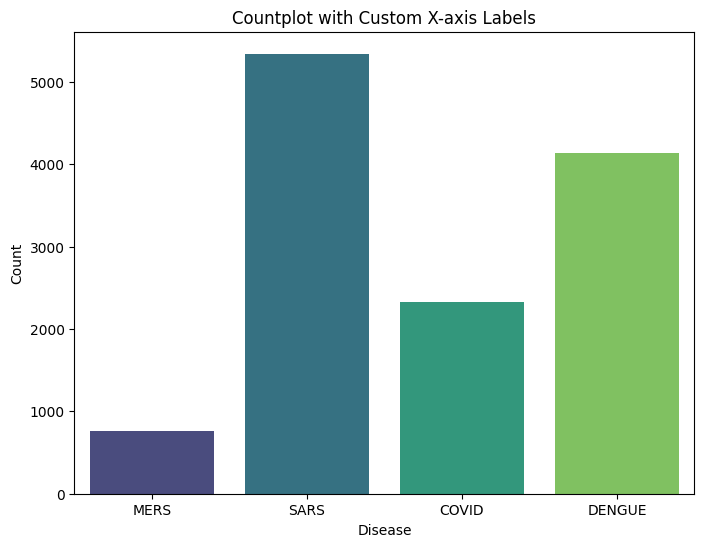

In [103]:
#
# Statistic label for each disease
#

custom_labels = {0: 'MERS', 1: 'SARS', 2: 'COVID', 3: 'DENGUE'}

# Create a countplot with custom x-axis labels
plt.figure(figsize=(8, 6))
sns.countplot(data=train_data,x='label', palette='viridis')
plt.xticks(ticks=sorted(custom_labels.keys()), labels=[custom_labels[i] for i in sorted(custom_labels.keys())])
plt.xlabel('Disease')
plt.ylabel('Count')
plt.title('Countplot with Custom X-axis Labels')
plt.show()

In [104]:
#
# get max_length to padding sequence 
# Note that: Devide 2 because devices are not enough :v bruh
#
# max_length = int(max([len(x) for x in train_data['dna']]) / 3)
max_length = 1000
max_length

1000

# Create model

In [105]:
#
# Create CNN model with keras
# A simpleRNN without any pretrained embeddings and one dense layer
#
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

model = keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=max_length,output_dim=8))
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=4, activation='softmax'))
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [97]:
#
# Create CNN model with keras
# A simpleRNN without any pretrained embeddings and one dense layer
#
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.01)

model = keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=max_length,output_dim=8))
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.LSTM(units = 512))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dense(units=4, activation='softmax'))
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [124]:
#
# Create CNN model with keras
# A simpleRNN without any pretrained embeddings and one dense layer
#
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

nerual_model = keras.Sequential()
nerual_model.add(layers.Dense(units=256, activation='relu'))
nerual_model.add(layers.Dropout(rate=0.2))
nerual_model.add(layers.Dense(units=128, activation='relu'))
nerual_model.add(layers.Dropout(rate=0.2))
nerual_model.add(layers.Dense(units=4, activation='softmax'))
nerual_model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

nerual_model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train model

In [106]:
data_padding = pad_sequences(train_data['dna'], maxlen=max_length,value=0,padding='post')

In [107]:
#
# One-hot encoding label
#
y_tf = tf.keras.utils.to_categorical(train_data['label'], num_classes = 4)
y_tf = np.array(y_tf, dtype=int)

In [111]:
#
# Splitting data
#
dna_train, dna_test, label_train, label_test = train_test_split(data_padding, y_tf, test_size = 0.2, random_state=42)

In [109]:
#
# Training model and save to history to get loss and accuracy history per epoch
#
# callback = keras.callbacks.EarlyStopping(monitor='loss', start_from_epoch=3)
history = model.fit(dna_train ,label_train, batch_size=32, epochs=7)

Epoch 1/7
 20/315 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4325 - loss: 1.2028

I0000 00:00:1714904016.439437      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


315/315 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.7186 - loss: 0.6671
Epoch 2/7
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8852 - loss: 0.2552
Epoch 3/7
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9173 - loss: 0.1857
Epoch 4/7
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9300 - loss: 0.1504
Epoch 5/7
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9455 - loss: 0.1050
Epoch 6/7
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9469 - loss: 0.0993
Epoch 7/7
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9493 - loss: 0.0893


# SVM

In [110]:
#
# Splitting data
#
dna_train, dna_test, label_train, label_test = train_test_split(data_padding, train_data['label'], test_size = 0.2, random_state=42)

In [44]:
from sklearn.svm import SVC

model = SVC(kernel = 'rbf')
model.fit(dna_train, label_train)

SVC()

In [45]:
test_prediction = model.predict(dna_test)
test_prediction

array([3, 2, 3, ..., 1, 3, 1])

In [46]:
print(classification_report(test_prediction, label_test))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       251
           1       0.99      0.90      0.94       677
           2       0.93      0.94      0.93       640
           3       0.97      0.98      0.97       872

    accuracy                           0.95      2440
   macro avg       0.93      0.95      0.94      2440
weighted avg       0.95      0.95      0.95      2440



In [123]:
mers_data_test = read_data('/kaggle/input/dna-sequence-testing/SARS_TEST.fasta')
mers_data_encoding = data_preprocessing(mers_data_test)

In [39]:
covid_data_test = read_data('/kaggle/input/dna-sequence-testing/COVID_TEST.fasta')
covid_data_encoding = data_preprocessing(covid_data_test)

In [124]:
p = pad_sequences(mers_data_encoding, maxlen=max_length,value=0,padding='post')

In [129]:
results = model.predict(p)
results[:3]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


array([[3.8124654e-05, 9.9995315e-01, 8.0930831e-06, 5.6245528e-07],
       [5.1179933e-07, 9.9999166e-01, 7.7225795e-06, 1.1987734e-07],
       [5.1179933e-07, 9.9999166e-01, 7.7225795e-06, 1.1987734e-07]],
      dtype=float32)

In [130]:
results = np.argmax(results, axis = 1)
results[:3]

array([1, 1, 1])

In [131]:
print('accuracy:' ,round(list(results).count(1) / len(list(results)), 2))

accuracy: 0.99


# Test model

In [112]:
test_prediction = model.predict(dna_test)
test_prediction[0]

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


array([8.0415557e-06, 9.9997842e-01, 1.3481142e-05, 5.5388313e-08],
      dtype=float32)

In [113]:
test_pre = np.argmax(test_prediction, axis = 1)
test_label = np.argmax(label_test, axis = 1)

In [114]:
print(classification_report(test_pre, test_label))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88       126
           1       0.89      0.88      0.88      1119
           2       0.74      0.71      0.73       457
           3       0.99      0.99      0.99       815

    accuracy                           0.89      2517
   macro avg       0.85      0.90      0.87      2517
weighted avg       0.89      0.89      0.89      2517



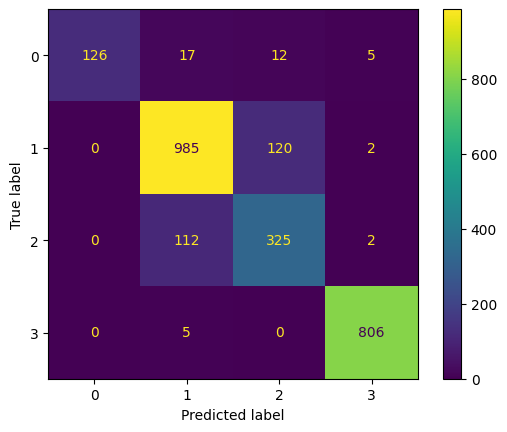

In [115]:
cm = confusion_matrix(test_label, test_pre, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
disp.plot()

In [116]:
accuracy_his = history.history['accuracy']
loss_his = history.history['loss']

In [117]:
epoch = [i + 1 for i in range(len(accuracy_his))]
epoch

[1, 2, 3, 4, 5, 6, 7]

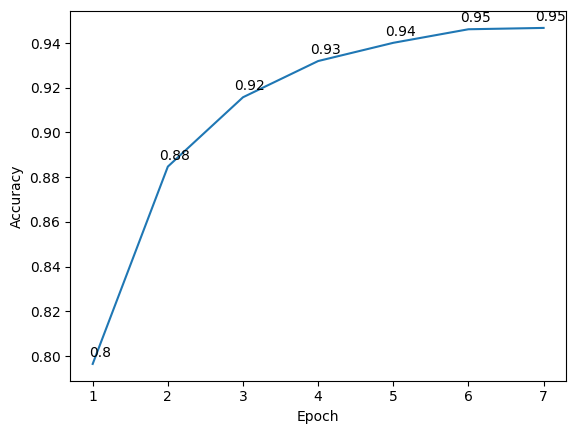

In [118]:
#
# Display accuracy history
#
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epoch, accuracy_his)
for i, (xi, yi) in enumerate(zip(epoch, accuracy_his)):
    plt.annotate(f'{round(yi,2)}', (xi, yi), textcoords="offset points", xytext=(5, 5), ha='center')
plt.show()

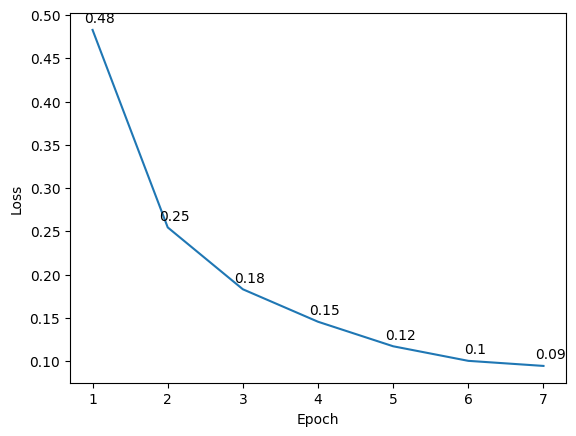

In [119]:
#
# Display loss history
#
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epoch, loss_his)
for i, (xi, yi) in enumerate(zip(epoch, loss_his)):
    plt.annotate(f'{round(yi,2)}', (xi, yi), textcoords="offset points", xytext=(5, 5), ha='center')
plt.show()

# Protein Sequence Classification

# Data Preprocessing

In [133]:
#
# Change from sequence to int[], using mapping dict
#
amino_acid_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20}
def data_preprocessing(data):
    results = []
    for row in data:
        check = False
        arr = []
        for i in range(len(row)):
            if(row[i] not in amino_acid_dict.keys()):
                check = True
                break
            arr.append(amino_acid_dict[row[i]])
        if(check == False):
            results.append(arr)
    return results

In [134]:
#
# Read data
#
protein_mers_data = read_data('/kaggle/input/protein-sequence/MERS2.fasta')
protein_sars_data = read_data('/kaggle/input/protein-sequence/SARS_PROTEIN.fasta')
protein_covid_data = read_data('/kaggle/input/protein-sequence/COVID_PROTEIN.fasta')
protein_dengue_data = read_data('/kaggle/input/protein-sequence/DENGUE_PROTEIN.fasta')

In [135]:
#
# Encode data
#
protein_mers_encoding = data_preprocessing(protein_mers_data)
protein_sars_encoding = data_preprocessing(protein_sars_data)
protein_covid_encoding = data_preprocessing(protein_covid_data)
protein_dengue_encoding = data_preprocessing(protein_dengue_data)
# protein_influenza_encoding = data_preprocessing(protein_influenza_data)
# protein_hepatitis_encoding = data_preprocessing(protein_hepatitis_data)

In [ ]:
#
# Create label for each disease
#
protein_mers_label = [0] * len(protein_mers_encoding)
protein_sars_label = [1] * len(protein_sars_encoding)
protein_covid_label = [2] * len(protein_covid_encoding)
# protein_influenza_label = [3] * len(protein_influenza_encoding)
protein_dengue_label = [3] * len(protein_dengue_encoding)
# protein_hepatitis_label = [5] * len(protein_hepatitis_encoding)

In [136]:
protein_mers_data = pd.DataFrame({'protein': protein_mers_encoding})
protein_sars_data = pd.DataFrame({'protein': protein_sars_encoding})
protein_covid_data = pd.DataFrame({'protein': protein_covid_encoding})
protein_dengue_data = pd.DataFrame({'protein': protein_dengue_encoding})

In [138]:
protein_mers_data['length'] = protein_mers_data['protein'].apply(lambda x: len(x))
protein_sars_data['length'] = protein_sars_data['protein'].apply(lambda x: len(x))
protein_covid_data['length'] = protein_covid_data['protein'].apply(lambda x: len(x))
protein_dengue_data['length'] = protein_dengue_data['protein'].apply(lambda x: len(x))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

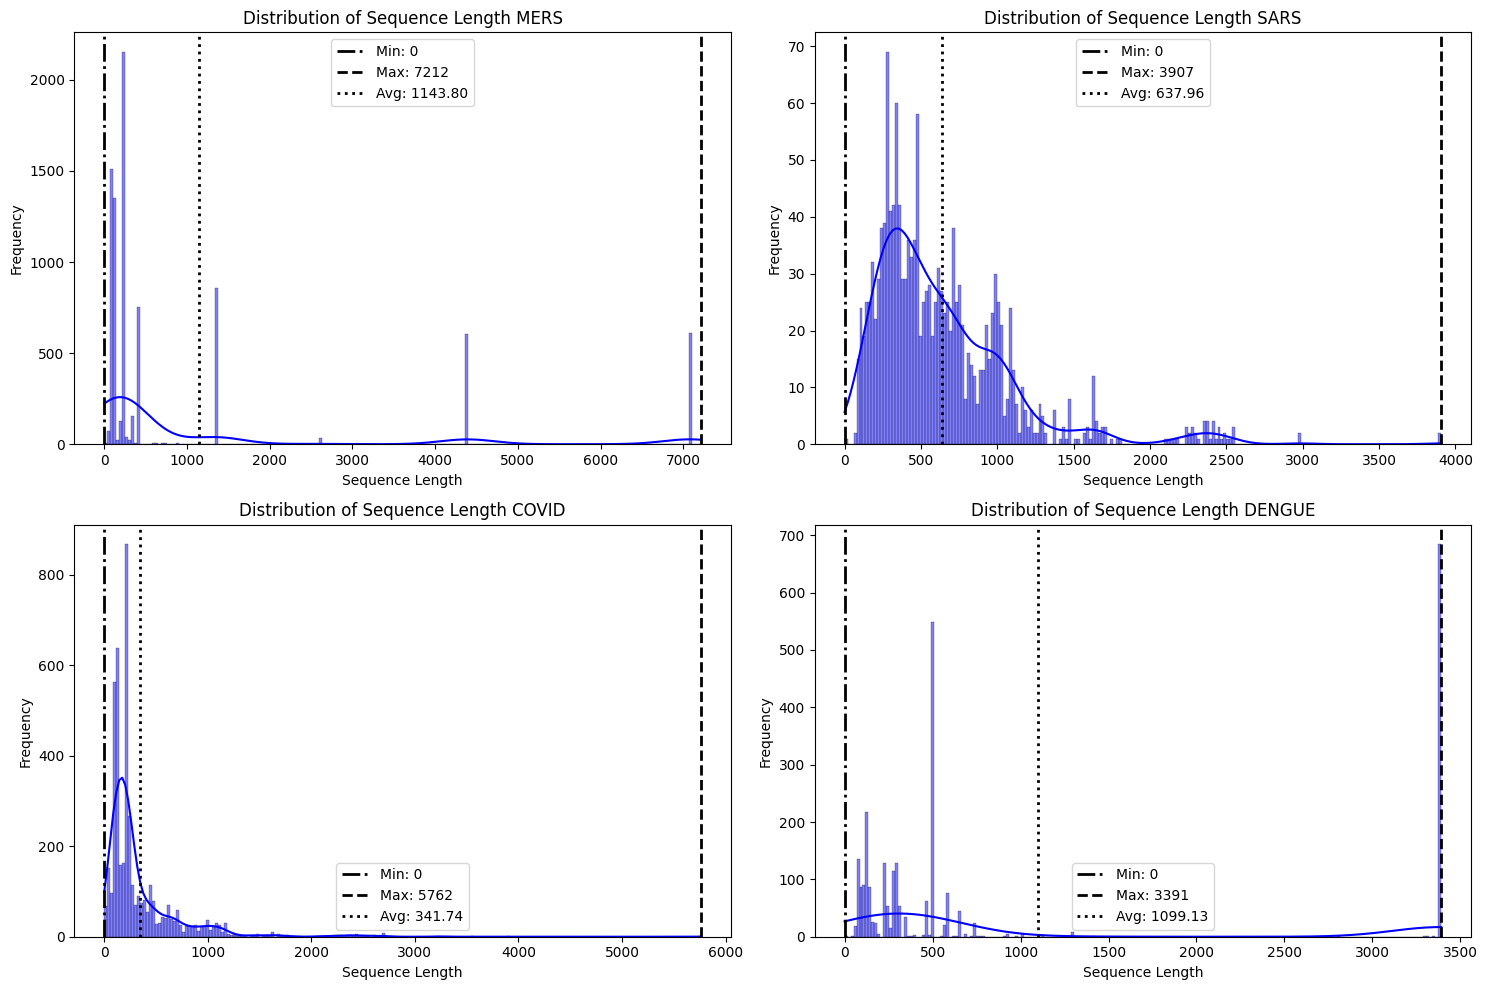

In [139]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
mapName = {0: 'MERS', 1: 'SARS', 2: 'COVID', 3: 'DENGUE'}

# Flatten axes thành một mảng 1D để dễ truy cập
axes = axes.flatten()

# Duyệt qua các tập dữ liệu và vẽ biểu đồ phân phối độ dài của chuỗi
for i, (dataset, ax) in enumerate(zip([protein_mers_data, protein_sars_data, protein_covid_data, protein_dengue_data], axes)):
    # Tính toán độ dài trung bình, tối thiểu và tối đa của chuỗi
    avg_length = dataset['length'].mean()
    max_length = dataset['length'].max()
    min_length = dataset['length'].min()
    
    # Vẽ biểu đồ phân phối độ dài chuỗi
    sns.histplot(dataset['length'], kde=True, color='blue', bins=200, ax=ax)
    ax.axvline(min_length, color='black', linestyle='dashdot', linewidth=2, label=f'Min: {min_length}')
    ax.axvline(max_length, color='black', linestyle='dashed', linewidth=2, label=f'Max: {max_length}')
    ax.axvline(avg_length, color='black', linestyle='dotted', linewidth=2, label=f'Avg: {avg_length:.2f}')
    ax.set_title(f'Distribution of Sequence Length {mapName[i]}')
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Frequency')
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
#
# Create data in form of 'DataFrame'
#
protein_train_data = pd.DataFrame({'protein': protein_mers_encoding + protein_sars_encoding + protein_covid_encoding + protein_dengue_encoding ,
                           'label': protein_mers_label + protein_sars_label + protein_covid_label + protein_dengue_label})
protein_train_data.head()

In [ ]:
#
# Drop duplicate sequences
#
protein_train_data.drop_duplicates(subset=['protein'], inplace=True)
protein_train_data.head()

In [ ]:
#
# Statistic per label
#
sns.countplot(data=protein_train_data, x = 'label')

In [ ]:
#
# Get max_length to pad sequence
#
# protein_max_length = int(max([len(x) for x in protein_train_data['protein']]))
protein_max_length = 2000
protein_max_length

# Create model

In [ ]:
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

model = keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=protein_max_length,output_dim=8))
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=4, activation='softmax'))
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Train model

In [ ]:
#
# Padding sequences
#
protein_data_padding = pad_sequences(protein_train_data['protein'], maxlen=protein_max_length,value=0,padding='post')

In [ ]:
#
# One-hot encoding label
#
y_tf = tf.keras.utils.to_categorical(protein_train_data['label'], num_classes = 4)
y_tf = np.array(y_tf, dtype=int)

In [ ]:
#
# Splitting data
#
protein_train, protein_test, label_train, label_test = train_test_split(protein_data_padding, y_tf, test_size = 0.2, random_state=42)

In [ ]:
#
# Training model and save to history to get loss and accuracy history per epoch
#
# callback = keras.callbacks.EarlyStopping(monitor='loss', start_from_epoch=3)
history = model.fit(protein_train ,label_train, batch_size=32, epochs=5)

# Test model

In [ ]:
test_prediction = model.predict(protein_test)
test_prediction[0]

In [ ]:
test_pre = np.argmax(test_prediction, axis = 1)
test_label = np.argmax(label_test, axis = 1)

In [ ]:
print(classification_report(test_pre, test_label))

In [ ]:
cm = confusion_matrix(test_label, test_pre, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
disp.plot()

In [ ]:
accuracy_his = history.history['accuracy']
loss_his = history.history['loss']

In [ ]:
epoch = [i + 1 for i in range(len(accuracy_his))]
epoch

In [ ]:
#
# Display accuracy history
#
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epoch, accuracy_his)
for i, (xi, yi) in enumerate(zip(epoch, accuracy_his)):
    plt.annotate(f'{round(yi,2)}', (xi, yi), textcoords="offset points", xytext=(5, 5), ha='center')
plt.show()

#
# Display loss history
#
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epoch, loss_his, color = 'red')
for i, (xi, yi) in enumerate(zip(epoch, loss_his)):
    plt.annotate(f'{round(yi,2)}', (xi, yi), textcoords="offset points", xytext=(5, 5), ha='center')
plt.show()

# **K-mer Encoding**

# DNA Sequence Classification

# *Preprocessing data*

In [52]:
k_mer = 10
def k_merEncoding(data):
    data = data_preprocessing(data)
    max_length = 1000
    dataPadding = pad_sequences(data, maxlen=max_length,value=0,padding='post')
    dataPadding = list(dataPadding)
    for i in range(len(dataPadding)):
        k_merEncode = [dataPadding[i][j:j+k_mer] for j in range(0, len(dataPadding[i]) - k_mer)]
        dataPadding[i] = k_merEncode
    return dataPadding

In [53]:
#
# K-mer Encoding data
#
mers_k_mer_encoding = k_merEncoding(mers_data)
sars_k_mer_encoding = k_merEncoding(sars_data[:3000])
covid_k_mer_encoding = k_merEncoding(covid_data)
dengue_k_mer_encoding = k_merEncoding(dengue_data)

In [54]:
#
# Labeling data
#
mers_label = [0] * len(mers_k_mer_encoding)
sars_label = [1] * len(sars_k_mer_encoding)
covid_label = [2] * len(covid_k_mer_encoding)
dengue_label = [3] * len(dengue_k_mer_encoding)

In [55]:
#
# Create data with DataFrame format
#
train_data = pd.DataFrame({'dna': mers_k_mer_encoding + sars_k_mer_encoding + covid_k_mer_encoding + dengue_k_mer_encoding, 'label': mers_label + sars_label + covid_label +dengue_label})
train_data.head()

,dna,label
0,"[[1, 1, 1, 4, 4, 1, 1, 4, 1, 2], [1, 1, 4, 4, ...",0
1,"[[1, 2, 4, 1, 4, 1, 3, 2, 4, 3], [2, 4, 1, 4, ...",0
2,"[[3, 1, 2, 1, 1, 1, 3, 4, 2, 1], [1, 2, 1, 1, ...",0
3,"[[1, 1, 4, 4, 4, 3, 4, 4, 4, 3], [1, 4, 4, 4, ...",0
4,"[[1, 1, 4, 4, 4, 3, 4, 4, 4, 3], [1, 4, 4, 4, ...",0


In [59]:
#
# get max_length to padding sequence 
# Note that: Devide 2 because devices are not enough :v bruh
#
# max_length = int(max([len(x) for x in train_data['dna']]) / 3)
max_length = 1000
max_length

1000

# *Create modal*

In [ ]:
#
# Create CNN model with keras
# A simpleRNN without any pretrained embeddings and one dense layer
#
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

model = keras.Sequential()
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', input_shape=(990, 10, 1)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=4, activation='softmax'))
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:

# A simpleRNN without any pretrained embeddings and one dense layer
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.005, use_ema=True)

cnn_lstm_model = keras.Sequential()
# cnn_lstm_model.add(TimeDistributed(Embedding(input_dim=max_length,output_dim=8)))
# cnn_lstm_model.add(layers.Input(shape=(32,990, 10, 1), batch_size=32))
cnn_lstm_model.add(TimeDistributed(Conv2D(filters=128, kernel_size=(1,10), activation='relu')))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
cnn_lstm_model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1,10), activation='relu')))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
cnn_lstm_model.add(TimeDistributed(Flatten()))

cnn_lstm_model.add(layers.LSTM(units=128, activation='tanh', unit_forget_bias=False))

cnn_lstm_model.add(Flatten())
cnn_lstm_model.add(Dense(units=128, activation='relu'))
cnn_lstm_model.add(Dense(units=4, activation='softmax'))

cnn_lstm_model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

cnn_lstm_model.summary()

# *Train model*

In [61]:
#
# One-hot encoding label
#
y_tf = tf.keras.utils.to_categorical(train_data['label'], num_classes = 4)
y_tf = np.array(y_tf, dtype=int)

In [62]:
#
# Convert list to numpy array
#
data = np.array([np.array(x) for x in train_data['dna']])

In [63]:
#
# Splitting data
#
dna_train, dna_test, label_train, label_test = train_test_split(data, y_tf, test_size = 0.2, random_state=42)

In [68]:
ex_dna_train = np.expand_dims(dna_train, axis = 1)
ex_dna_train.shape

(9760, 1, 990, 10)

In [ ]:
#
# Training model and save to history to get loss and accuracy history per epoch
#
# callback = keras.callbacks.EarlyStopping(monitor='loss', start_from_epoch=3)
history = model.fit(ex_dna_train ,label_train, batch_size=32, epochs=5)

# *Test model*

In [ ]:
test_prediction = model.predict(dna_test)
test_prediction[0]

In [ ]:
test_pre = np.argmax(test_prediction, axis = 1)
test_label = np.argmax(label_test, axis = 1)

In [ ]:
print(classification_report(test_pre, test_label))

In [ ]:
cm = confusion_matrix(test_label, test_pre, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
disp.plot()

In [ ]:
accuracy_his = history.history['accuracy']
loss_his = history.history['loss']

In [ ]:
epoch = [i + 1 for i in range(len(accuracy_his))]
epoch

In [ ]:
#
# Display accuracy history
#
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epoch, accuracy_his)
plt.show()

In [ ]:
#
# Display loss history
#
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epoch, loss_his)
plt.show()

# **Protein Sequence Classification**

In [ ]:
k_mer = 10
def k_merEncoding(data):
    data = data_preprocessing(data)
    max_length = 1000
    dataPadding = pad_sequences(data, maxlen=max_length,value=0,padding='post')
    dataPadding = list(dataPadding)
    for i in range(len(dataPadding)):
        k_merEncode = [dataPadding[i][j:j+k_mer] for j in range(0, len(dataPadding[i]) - k_mer)]
        dataPadding[i] = k_merEncode
    return dataPadding

# Rolling

In [3]:

# # A simpleRNN without any pretrained embeddings and one dense layer
# optimizers = tf.keras.optimizers.Adam(learning_rate = 0.005, use_ema=True)

# cnn_lstm_model = keras.Sequential()
# # cnn_lstm_model.add(TimeDistributed(Embedding(input_dim=max_length,output_dim=8)))
# cnn_lstm_model.add(TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='relu')))
# cnn_lstm_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# cnn_lstm_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=4, activation='relu')))
# cnn_lstm_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

# cnn_lstm_model.add(layers.LSTM(units=128, activation='tanh', unit_forget_bias=False))

# cnn_lstm_model.add(Flatten())
# cnn_lstm_model.add(Dense(units=128, activation='relu'))
# cnn_lstm_model.add(Dense(units=4, activation='softmax'))

# cnn_lstm_model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

# cnn_lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=42)
# data_padding, label = ros.fit_resample(data_padding, train_data['label'])

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=300,max_depth=14)
# clf.fit(dna_train, label_train)

In [ ]:
# label_pre = clf.predict(dna_test)
# print(classification_report(label_pre,label_test))
# print(accuracy_score(label_pre,label_test)*100)

In [ ]:
# from sklearn.metrics import accuracy_score

# accuracy_score(test_pre, test_label)

In [ ]:
# mers_data_test = read_data('/kaggle/input/dna-sequence-testing/SARS_TEST.fasta')
# mers_data_encoding = data_preprocessing(mers_data_test)

# influenza_data_test = read_data('/kaggle/input/dna-sequence-testing/INFLUENZA_TEST.fasta')
# influenza_data_encoding = data_preprocessing(influenza_data_test)

In [ ]:
# data_test = mers_data_encoding + influenza_data_encoding[:1000]

In [ ]:
# p = pad_sequences(influenza_data_encoding, maxlen=max_length,value=0,padding='post')

In [ ]:
# data_test_padding = pad_sequences(data_test, maxlen=max_length,value=0,padding='post')

In [ ]:
# import
# loaded_model = keras.saving.load_model("model.keras")

In [ ]:
# results = model.predict(p)
# results[:3]

In [ ]:
# pre = np.argmax(results, axis = 1)
# pre[:3]

In [ ]:
# actual_results = [1] * len(mers_data_encoding) + [3] * 1000

In [ ]:
# unique, counts = np.unique(pre, return_counts=True)
# dict(zip(unique, counts))

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# typeClass = ['CNN','CNN','CNN-LSTM','CNN-LSTM']
# typeEval = ['Label Encoding Training', 'Label Encoding Testing', 'Label Encoding Training', 'Label Encoding Testing']
# accuracy = [0.96, 0.92, 0.95, 0.93]
# accuracy_table = pd.DataFrame({'type': typeClass, 'typeEval': typeEval, 'accuracy': accuracy})

# sns.barplot(data = accuracy_table, x='typeEval', y='accuracy',hue = 'type', saturation=1, palette = "mako")
# plt.xlabel('')
# plt.ylabel('Accuracy (%)')
# plt.show()